# Acquisition functions

DeepSensor allows you to perform active learning with your models to propose new context locations that are expected to improve the model's predictions.

This notebook demonstrates how DeepSensor's available acquisition functions used with a greedy active learning algorithms to propose new context locations for a ConvNP model trained on ERA5 data.

For an up-to-date list of acquisition functions see the API documentation for the `deepsensor.active_learning.acquisition_fns` module: [](../reference/active_learning/acquisition_fns.rst)

## Set-up

In [1]:
import logging
logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.model import ConvNP
from deepsensor.active_learning import GreedyAlgorithm
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, \
    get_gldas_land_mask, get_ghcnd_station_data

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook


In [2]:
# Training/data config
data_range = ("2010-01-01", "2019-12-31")
train_range = ("2010-01-01", "2018-12-31")
val_range = ("2019-01-01", "2019-12-31")
date_subsample_factor = 2
extent = "usa"
station_var_IDs = ["TAVG"]
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "../../.datacache"
deepsensor_folder = "../deepsensor_config/"
model_folder = "../model/"
verbose_download = True

val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]

In [3]:
crs = ccrs.PlateCarree()
test_date = pd.Timestamp("2019-06-25")

In [4]:
# Run on GPU if available by setting GPU as default device
# set_gpu_default_device()

In [5]:
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir, verbose=verbose_download, num_processes=8)
lowres_aux_raw_ds = get_earthenv_auxiliary_data(lowres_auxiliary_var_IDs, extent, "100KM", cache=True, cache_dir=cache_dir, verbose=verbose_download)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir, verbose=verbose_download)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
lowres_aux_ds, land_mask_ds = data_processor([lowres_aux_raw_ds, land_mask_raw_ds], method="min_max")

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]


100%|██████████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 42.94it/s]


1.41 GB loaded in 4.22 s


In [6]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [7]:
# Load model
model = ConvNP(data_processor, task_loader, deepsensor_folder)

## Active learning

In [8]:
X_c = 100

In [9]:
task = task_loader(test_date, (X_c, "all", "all"), seed_override=42)

In [10]:
# xarray object containing a mask to remove ocean points from the search and target points
mask_ds = land_mask_raw_ds

### Sequential greedy algorithm

Sequentially loop over all search points, passing a query observation to the model at that point and computing the change in acquisition function

In [11]:
greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=15, lon=15, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    N_new_context=3,
    progress_bar=True,
)

Minimise the model's mean standard deviation - i.e. minimise the expected MAE under the model.

100%|██████████████████████████████████████████████████████████████████| 579/579 [02:15<00:00,  4.29it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaging acquisition function over dims for plotting: ['time']


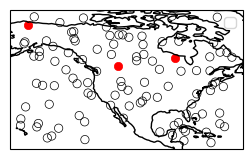

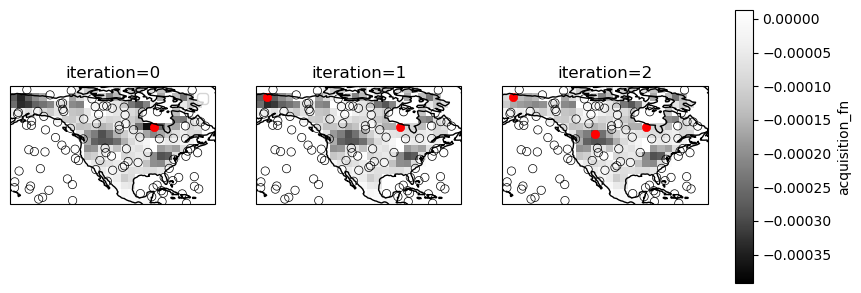

In [12]:
from deepsensor.active_learning.acquisition_fns import MeanStddev

acquisition_fn = MeanStddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

Computing the p-norm of the standard deviations can be used to place greater emphasis on reducing the largest standard deviations

100%|██████████████████████████████████████████████████████████████████| 579/579 [02:10<00:00,  4.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaging acquisition function over dims for plotting: ['time']


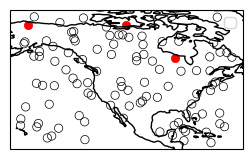

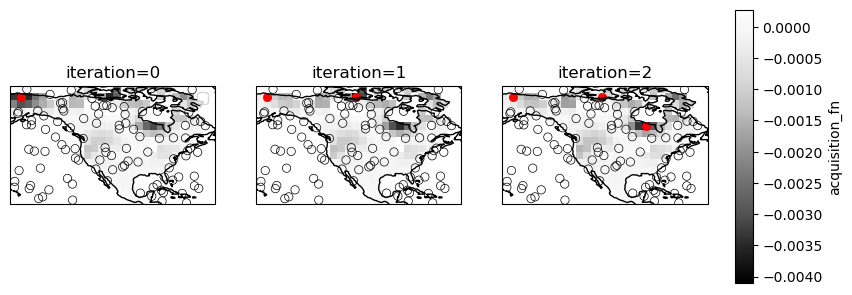

In [13]:
from deepsensor.active_learning.acquisition_fns import pNormStddev

acquisition_fn = pNormStddev(model, p=6)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

### Oracle sequential greedy algorithm

Acquisition functions that use the true target values to compute performance metrics. In this case we must pass `GreedyAlgorithm` the `task_loader` object so that it can load the true target values for each target point.

In [14]:
greedy_alg_with_groundtruth = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=10, lon=10, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    query_infill=era5_ds,
    proposed_infill=era5_ds,
    N_new_context=3,
    task_loader=task_loader,
    verbose=True,
    progress_bar=True,
)

query_infill not on search grid, interpolating.
proposed_infill not on search grid, interpolating.


In [15]:
from deepsensor.active_learning.acquisition_fns import OracleMAE

acquisition_fn = OracleMAE(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

 80%|███████████████████████████████████████████████████▏            | 1049/1311 [03:59<00:59,  4.38it/s]


KeyboardInterrupt: 

In [ ]:
from deepsensor.active_learning.acquisition_fns import OracleRMSE

acquisition_fn = OracleRMSE(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

In [ ]:
from deepsensor.active_learning.acquisition_fns import OracleMarginalNLL

acquisition_fn = OracleMarginalNLL(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

### Parallel greedy algorithm

Acquisition functions that inherit from `AcquisitionFunctionParallel` can be computed over all search points in parallel by running the model forwards once. These are much faster to compute, enabling finer search grids, averaging acquisition functions over more tasks, and more proposed context points. However, sequential acquisition functions that run the model forwards once per search point will likely be more informative.

In [ ]:
greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds,
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    N_new_context=10,
)

In [ ]:
from deepsensor.active_learning.acquisition_fns import Stddev
dates = val_dates[0:1]
tasks = task_loader(dates, (X_c, "all", "all"), seed_override=42)

### Stddev

Use the model's standard deviation at search points as the acquisition function. Maximising this acquisition function will place context points at locations where the model is most uncertain.

In [ ]:
acquisition_fn = Stddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks)

fig = deepsensor.plot.placements(tasks[0], X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 4)), X_new_df, data_processor, crs, cmap="Greys")

### ExpectedImprovement

The Expected Improvement acquisition function can be used to hunt for the most positive or negative values in the data. In this case we will use the `ExpectedImprovement` acquisition function to search for the greatest temperature values over Antarctica. We will average the acquisition function over tasks sampled from 52 equally spaced dates in 2020 to make the acquisition function more robust to the weather on a single day.

In [ ]:
greedy_alg_with_groundtruth = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds,
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    proposed_infill=era5_ds,  # EI requires ground truth after proposal
    N_new_context=10,
    verbose=True,
)

In [ ]:
from deepsensor.active_learning.acquisition_fns import ExpectedImprovement

acquisition_fn = ExpectedImprovement(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, tasks)

In [ ]:
fig = deepsensor.plot.placements(tasks[0], X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 55, 5)), X_new_df, data_processor, crs, cmap="Greys", add_colorbar=False, max_ncol=5)

### ContextDist

Distance to the closest context point. Maximising this acquisition function will place context points at locations that are furthest from existing context points.

In [ ]:
from deepsensor.active_learning.acquisition_fns import ContextDist

acquisition_fn = ContextDist(0)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks[0])

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 55, 5)), X_new_df, data_processor, crs, cmap="Greys", add_colorbar=False, max_ncol=5)

### Random

Random acquisition function leading to placements - a useful baseline!

In [ ]:
from deepsensor.active_learning.acquisition_fns import Random

acquisition_fn = Random()
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks[0])

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)